# Bare BCS for sparse signal detection from noisy data

This notebook uses BCS to determine a set of sparse coefficients in a basis set to best approximate the observed data. 
Note that this example does not presume a PCE set of basis functions. Arbitrary basis functions can be used.
The example shown here borrows heavily from the scikit-learn example on Ortogonal Matching Pursuit (OMP)

https://scikit-learn.org/stable/auto_examples/linear_model/plot_omp.html

In [1]:
import numpy as np
import PyUQTk.PyPCE.pce_tools as pce_tools
import matplotlib.pyplot as plt
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV
from sklearn.datasets import make_sparse_coded_signal
import sklearn.metrics as sklm
import sklearn.model_selection as skms


PyMC is required for some of the MCMC postprocessing codes.
Will proceed without, but some convergence tests will not be available.


### Set up the problem

In [2]:
# Example input parameters
n_c = 500     # number of basis terms
n_y_trn = 100 # number of y samples for training
n_y_tst = 500 # number of y samples for testing
n_nz_c = 20   # number of nonzero coeffs in the basis set
n_y_tot = n_y_trn + n_y_tst # Request enough y samples for both training and testing.
noise_sig = 0.05 # imposed data noise std dev.


# generate the data using sparse coded signal example in scikit-learn

# System of equations: y = A coeffs
# y (n_features, n_samples)
# A (n_features, n_components)
# coeffs (n_components, n_samples)
# n_samples = 1 (is more like a set of replicate problems)
# |coeffs|_0 = n_nonzero_coefs

ys, A, coeffs = make_sparse_coded_signal(
    n_samples=1,
    n_components=n_c,
    n_features=n_y_tot,
    n_nonzero_coefs=n_nz_c,
    random_state=0,
    data_transposed=True,
    )

(idc_true,) = coeffs.nonzero() # Indices of non-zero coefficients

# Separate out testing and training samples
ys_trn = ys[:n_y_trn] # Training data
ys_tst = ys[n_y_trn:] # Testing data
A_trn = A[:n_y_trn,:] # Training data basis function evaluations
A_tst = A[n_y_trn:,:] # Testing data basis function evaluations

In [3]:
# add noise to the outputs
ys_noisy = ys_trn + noise_sig * np.random.randn(len(ys_trn))

### Infer sparse coefficients with OMP

In [4]:
# reconstruction of coefficients with OMP
omp_cv = OrthogonalMatchingPursuitCV()
omp_cv.fit(A_trn, ys_noisy)
omp_coef = omp_cv.coef_
(idc_omp,) = omp_coef.nonzero()
print("OMP selected %d nonzero coefficients"%(len(idc_omp)))

OMP selected 10 nonzero coefficients


### Infer sparse coefficients with BCS using cross-validation to determine optimal tolerance

In [5]:
# Set up k-fold cross validation to get optimal stopping criterion
n_folds = 5
my_k_folds = skms.KFold(n_folds)

# Estimated data noise variance
data_noise_sig2 = 0.02

tols = 10.**(- np.arange(5,14))    # tolerance ranges from 1.e-5 to 1.e-14
cv_errs = np.zeros_like(tols)      # To store average crossvalidation errors for each tolerance

for i_t, tol in enumerate(tols):
    errs = np.zeros((n_folds,))
    for k, (train, test) in enumerate(my_k_folds.split(A_trn, ys_noisy)):
        # BCS using training data for this fold
        bcs_coef_k = pce_tools.UQTkCallBCSDirect(A_trn[train],ys_noisy[train],data_noise_sig2,tol,verbose=False)
        # predict the testing data for this fold
        y_pred_k = np.matmul(A_trn[test],bcs_coef_k)
        # Get rmese error on testing data for this fold
        errs[k] = sklm.mean_squared_error(ys_noisy[test],y_pred_k,squared=False)
    # Get averaged error over all folds for this tolerance
    cv_errs[i_t] = errs.mean()
    
tol_opt = tols[np.argmin(cv_errs)]
print("Cross-validation selected an optimal tolerance of %.1e"%tol_opt)

Cross-validation selected an optimal tolerance of 1.0e-06


In [6]:
# reconstruction of coefficients with BCS against full training data set
bcs_coef = pce_tools.UQTkCallBCSDirect(A_trn,ys_noisy,data_noise_sig2,tol_opt,verbose=True)
(idc_bcs,) = bcs_coef.nonzero()

BCS has selected 18 basis terms out of 500 basis terms


### Compare against testing data

In [7]:
# Compare predictions with inferred signal against the testing data
y_pred_omp = np.matmul(A_tst,omp_coef)
y_pred_bcs = np.matmul(A_tst,bcs_coef)
omp_rmse = sklm.mean_squared_error(ys_tst,y_pred_omp,squared=False)
bcs_rmse = sklm.mean_squared_error(ys_tst,y_pred_bcs,squared=False)
print("RMSE on testing data:")
print("  OMP: %.3e"%omp_rmse)
print("  BCS: %.3e"%bcs_rmse)

RMSE on testing data:
  OMP: 6.279e-02
  BCS: 5.515e-02


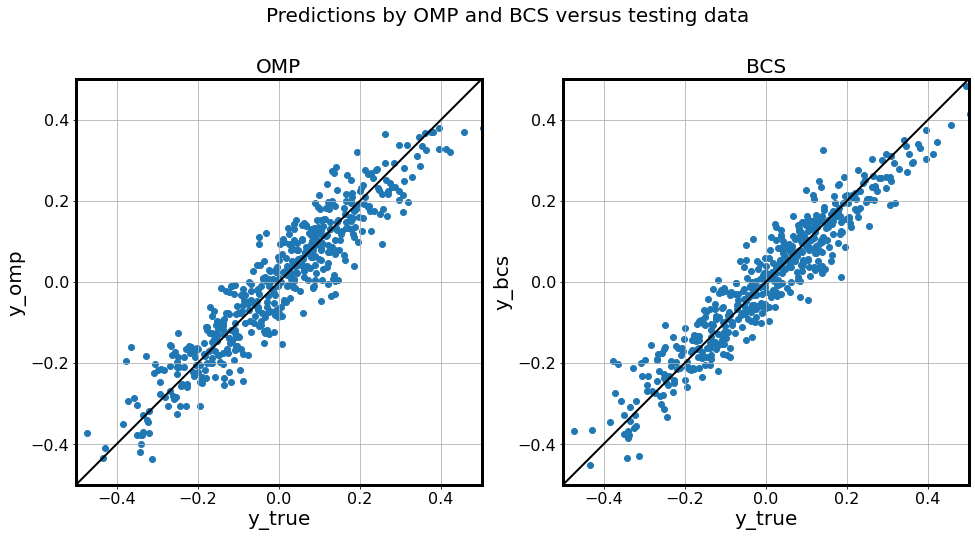

In [8]:
# Plot predictions versus testing data
# Make one plot with the two graphs side by side
fig1, ax1 = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
fig1.suptitle("Predictions by OMP and BCS versus testing data", fontsize=20)

y_min = ys_tst.min()
y_max = ys_tst.max()

identity_line=np.array([[y_min,y_min],[y_max,y_max]])

# OMP
ax1[0].plot(identity_line[:,0],identity_line[:,1],color="black",linewidth=2)
ax1[0].scatter(ys_tst,y_pred_omp)
ax1[0].set_title("OMP" , fontsize=20)
ax1[0].tick_params(axis='both', labelsize= 16)
ax1[0].set_xlim(-0.5,0.5)
ax1[0].set_ylim(-0.5,0.5)
ax1[0].set_xlabel("y_true", fontsize=20)
ax1[0].set_ylabel("y_omp", fontsize=20)
ax1[0].set_aspect(1.0)

# BCS
ax1[1].plot(identity_line[:,0],identity_line[:,1],color="black",linewidth=2)
ax1[1].scatter(ys_tst,y_pred_bcs)
ax1[1].set_title("BCS" , fontsize=20)
ax1[1].tick_params(axis='both', labelsize= 16)
ax1[1].set_xlim(-0.5,0.5)
ax1[1].set_ylim(-0.5,0.5)
ax1[1].set_xlabel("y_true", fontsize=20)
ax1[1].set_ylabel("y_bcs", fontsize=20)
ax1[1].set_aspect(1.0)

plt.show()